# Imports

In [18]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import torch
from transformer_lens import HookedTransformer
from sae_lens import SAE

from huggingface_hub import notebook_login

# notebook_login()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model and SAE

- Use Gemma 2 2b
- Start with 16k SAE, all layers (1-25)

In [21]:
model = HookedTransformer.from_pretrained("gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


In [23]:
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res",
    sae_id="layer_10/width_16k/average_l0_77",
    device="cuda",
)

# Load dataset

In [24]:
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset("codeparrot/apps", split="train")

Check dataset looks good

In [25]:
from collections import Counter
import json

# Print the dataset size
print(f"Dataset size: {len(dataset)}")

# Get a count of all difficulties
difficulty_counts = Counter(sample['difficulty'] for sample in dataset)

# Print the counts
print("\nDifficulties in sample:")
for difficulty, count in difficulty_counts.items():
    print(f"{difficulty}: {count}")

# Print the first sample
sample = next(iter(dataset))
sample["solutions"] = json.loads(sample["solutions"])
sample["input_output"] = json.loads(sample["input_output"])
print(sample)

Dataset size: 5000

Difficulties in sample:
interview: 2000
competition: 361
introductory: 2639
{'problem_id': 0, 'question': 'Polycarp has $n$ different binary words. A word called binary if it contains only characters \'0\' and \'1\'. For example, these words are binary: "0001", "11", "0" and "0011100".\n\nPolycarp wants to offer his set of $n$ binary words to play a game "words". In this game, players name words and each next word (starting from the second) must start with the last character of the previous word. The first word can be any. For example, these sequence of words can be named during the game: "0101", "1", "10", "00", "00001".\n\nWord reversal is the operation of reversing the order of the characters. For example, the word "0111" after the reversal becomes "1110", the word "11010" after the reversal becomes "01011".\n\nProbably, Polycarp has such a set of words that there is no way to put them in the order correspondent to the game rules. In this situation, he wants to r

In [78]:
print(sample["solutions"])
print(len(sample["solutions"]))

["for _ in range(int(input())):\n    n = int(input())\n    mass = []\n    zo = 0\n    oz = 0\n    zz = 0\n    oo = 0\n    ozs = []\n    zos = []\n    ozss = set()\n    zoss = set()\n    for j in range(n):\n        k = input()\n        mass.append(k)\n        if k[0] == '0' and k[-1] == '1':\n            zoss.add(k)\n            zos.append(j + 1)\n            zo += 1\n        elif k[0] == '1' and k[-1] == '0':\n            ozss.add(k)\n            ozs.append(j + 1)\n            oz += 1\n        elif k[0] == '0' and k[-1] == '0':\n            zz += 1\n        else:\n            oo += 1\n    if zz and oo and not oz and not zo:\n        print(-1)\n        continue\n    else:\n        if zo > oz:\n            print((zo - oz) // 2)\n            ans = []\n            need = (zo - oz) // 2\n            i = 0\n            while need:\n                zzz = mass[zos[i] - 1][len(mass[zos[i] - 1]) - 1:: -1]\n                if zzz not in ozss:\n                    ans.append(zos[i])\n             

# Want the following:

Run the model over each problem in the dataset. 

Should result in the following dataset, with one row per token in each problem:
- `problem_id`: unique identifier for each problem
- `token_pos`: token position in the problem
- `token_idx`: token index in the model
- `token_str`: string representation of the token

In [26]:
import pandas as pd
from sae_lens import ActivationsStore

def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

def create_batch_df(
    tokens,
    len_prefix=5, 
    len_suffix=3, 
    model=model,
):
    str_tokens = [model.to_str_tokens(t) for t in tokens]
    
    context = []
    prompt = []
    pos = []
    label = []
    subsequence = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p == tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            prompt.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
            subsequence.append("".join(str_tokens[b][:p+1]))  # Add subsequence
    
    return pd.DataFrame(dict(
        problem_idx=prompt, 
        token_pos=pos, 
        token_str=list_flatten(str_tokens),
        token_lab=label,
    ))

I might want to merge this back onto the original data by `problem_id` so because I'm lazy I'll just concatenate the 5 solutions per problem into one string... Shouldn't matter much whether they're broken out individually.

In [43]:
import pandas as pd
import os

def generate_and_save_activations(
    dataset,
    model: HookedTransformer, 
    sae: SAE, 
    output_dir: str,
    batches_to_run: int = None,
    batch_size_prompts = 1,
    batch_size_tokens = 4096,
    sae_max_activations = 200, # only stores this many activation columns
    force = False # if True, will overwrite existing files
):
    """
    Iterates through the code dataset creating a dataframe of 
    feature activations at each token, saving batches to disk.
    """
    
    tokenized_dataset = tokenize_and_concatenate(
        dataset=dataset,
        tokenizer=model.tokenizer,
        column_name="solutions",
        max_length=sae.cfg.context_size, 
        add_bos_token=sae.cfg.prepend_bos
    )
    
    activation_store = ActivationsStore.from_sae(
        model=model,
        sae=sae,
        dataset=tokenized_dataset,  
        streaming=True,
        store_batch_size_prompts=batch_size_prompts,
        train_batch_size_tokens=batch_size_tokens,
        n_batches_in_buffer=32,
        device="cuda",
    )
    
    os.makedirs(output_dir, exist_ok=True)
    
    tokens = activation_store.get_batch_tokens()
    batch_idx = 0

    while tokens is not None:
        if batches_to_run and batch_idx >= batches_to_run:
            break
        
        output_file = os.path.join(output_dir, f'batch_{batch_idx}.parquet')
        print(f"[{output_dir}] Processing batch {batch_idx}")
        
        if not force and os.path.exists(output_file):
            print("Skipping batch, already exists")
        else:
            # Initialize activation dataset
            df = create_batch_df(tokens)
            
            # Run model with cache
            _, cache = model.run_with_cache(tokens, stop_at_layer=sae.cfg.hook_layer + 1, names_filter=[sae.cfg.hook_name])
            
            # Get SAE activations
            sae_in = cache[sae.cfg.hook_name]
            feature_acts = sae.encode(sae_in).squeeze()
            
            # Get the indices of the top k activations
            positive_acts = feature_acts * (feature_acts > 0)
            top_k_indices = torch.argsort(positive_acts, dim=-1, descending=True)[:, :sae_max_activations]
            
            # Create a mask for positive activations
            positive_mask = torch.gather(positive_acts, 1, top_k_indices) > 0
            
            # Apply the mask to top_k_indices
            masked_indices = torch.where(positive_mask, top_k_indices, torch.tensor(0, device=top_k_indices.device))
            
            # Convert to numpy and create DataFrame
            activation_dict = {f'activation_{i}': masked_indices[:, i].cpu().numpy() for i in range(sae_max_activations)}
            
            # Add all feature columns at once
            df = pd.concat([df, pd.DataFrame(activation_dict)], axis=1)
            
            # Save the dataframe to disk
            df.to_parquet(output_file)

            
        # Get a new batch of tokens
        batch_idx += 1 
        try:
            tokens = activation_store.get_batch_tokens(raise_at_epoch_end=True)
        except StopIteration:
            tokens = None

In [38]:
def load_activations(input_dir: str):
    """Loads activations from disk, combining them into a dataframe."""
    
    all_dfs = []
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.parquet'):
            file_path = os.path.join(input_dir, filename)
            df = pd.read_parquet(file_path)
            
            # Extract batch number from filename
            batch_num = int(filename.split('_')[1].split('.')[0])
            
            # Add batch column
            df['batch'] = batch_num
            
            # Create unique problem_id
            df['problem_id'] = df['batch'].astype(str) + '-' + df['problem_idx'].astype(str)
            
            all_dfs.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    return combined_df

# Generate activation dataset for just the easy problems

In [ ]:
easy_dataset = dataset.filter(lambda x: x['difficulty'] == 'introductory')
assert len(easy_dataset) > 0

In [66]:
test_dir = '/root/data/test'

generate_and_save_activations(
    dataset=easy_dataset,
    model=model,
    sae=sae,
    output_dir=test_dir,
    batches_to_run=10, # only run a few
)

test_df = load_activations(test_dir)

In [67]:
test_df.head()

,problem_idx,token_pos,token_str,token_lab,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,...,activation_192,activation_193,activation_194,activation_195,activation_196,activation_197,activation_198,activation_199,batch,problem_id
0,0,0,<bos>,0/0,4392,2843,3736,2575,5501,6655,...,5972,11254,12839,16048,3893,9764,16251,15472,0,0-0
1,0,1,<bos>,0/1,4392,2843,3736,2575,5501,6655,...,5972,11254,12839,16048,3893,9764,16251,15472,0,0-0
2,0,2,"[""",0/2,4392,3736,14372,381,1692,13213,...,0,0,0,0,0,0,0,0,0,0-0
3,0,3,from,0/3,14319,15603,14028,3986,1157,786,...,0,0,0,0,0,0,0,0,0,0-0
4,0,4,collections,0/4,14137,3986,6710,12238,14028,3279,...,0,0,0,0,0,0,0,0,0,0-0


# Check test run

Summary statistics for features fired per token:
count    10240.000000
mean        74.704785
std         25.332107
min         10.000000
25%         58.000000
50%         71.000000
75%         87.000000
max        200.000000
Name: features_fired, dtype: float64

Percentage of tokens with at least one feature firing: 100.00%


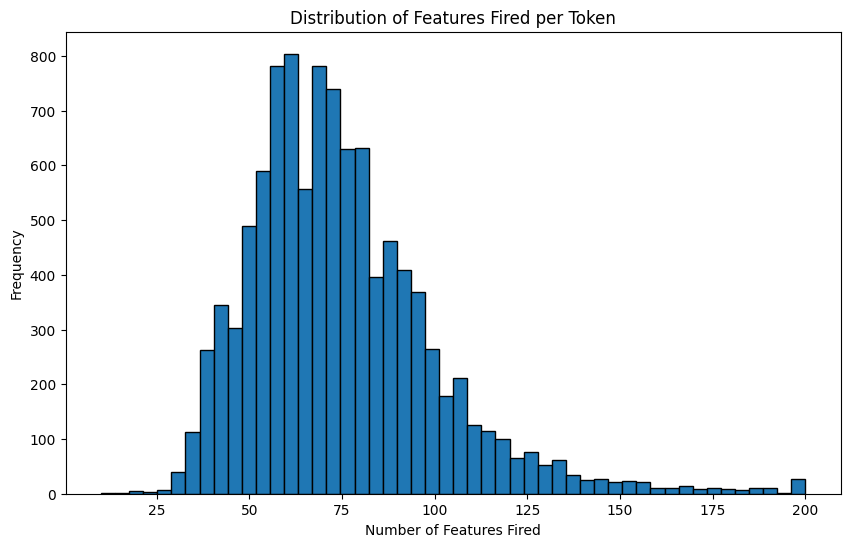

In [68]:
# Calculate the number of features that fired for each token
activation_columns = [col for col in test_df.columns if col.startswith('activation_')]
test_df['features_fired'] = (test_df[activation_columns] > 0).sum(axis=1)

# Calculate summary statistics
summary_stats = test_df['features_fired'].describe()

print("Summary statistics for features fired per token:")
print(summary_stats)

# Calculate the percentage of tokens with at least one feature firing
tokens_with_firing = (test_df['features_fired'] > 0).sum()
total_tokens = len(test_df)
percentage_with_firing = (tokens_with_firing / total_tokens) * 100

print(f"\nPercentage of tokens with at least one feature firing: {percentage_with_firing:.2f}%")

# Plot a histogram of features fired per token
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(test_df['features_fired'], bins=50, edgecolor='black')
plt.title('Distribution of Features Fired per Token')
plt.xlabel('Number of Features Fired')
plt.ylabel('Frequency')
plt.show()

Why so many at 200?

In [69]:
high_firing_rows = test_df[test_df['features_fired'] > 195]
high_firing_rows = high_firing_rows.sort_values('features_fired', ascending=False)
print(len(high_firing_rows))
high_firing_rows[['problem_id', 'token_pos', 'token_str', 'features_fired']]

26


,problem_id,token_pos,token_str,features_fired
0,0-0,0,<bos>,200
1,0-0,1,<bos>,200
9216,9-0,0,<bos>,200
8192,8-0,0,<bos>,200
7699,7-0,531,bisect,200
7168,7-0,0,<bos>,200
6144,6-0,0,<bos>,200
5120,5-0,0,<bos>,200
4096,4-0,0,<bos>,200
3072,3-0,0,<bos>,200


Ok not a huge deal.

In [73]:
easy_problem_dir = '/root/data/introductory'

# generate_and_save_activations(
#     dataset=easy_dataset,
#     model=model,
#     sae=sae,
#     output_dir=easy_problem_dir,
# )

easy_df = load_activations(easy_problem_dir)

# Check full activation dataset

Summary statistics for features fired per token:
count    10240.000000
mean        74.704785
std         25.332107
min         10.000000
25%         58.000000
50%         71.000000
75%         87.000000
max        200.000000
Name: features_fired, dtype: float64

Percentage of tokens with at least one feature firing: 100.00%


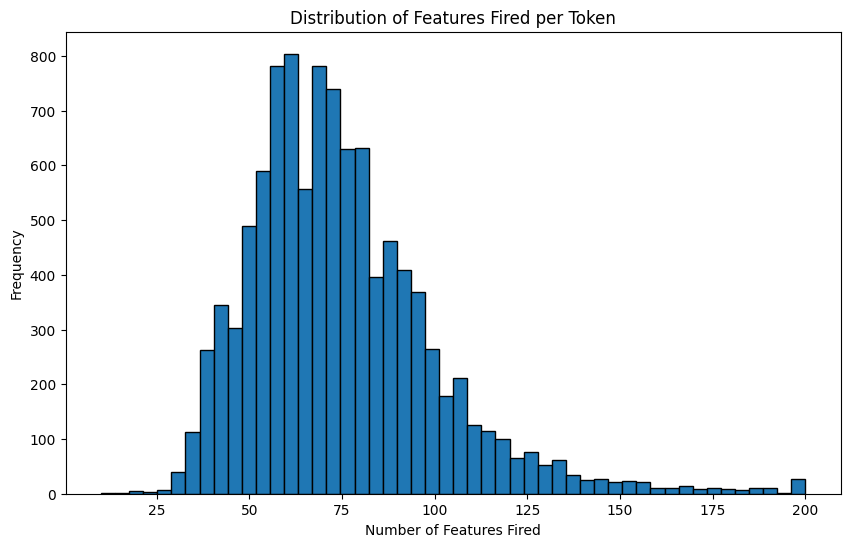

In [74]:
# Calculate the number of features that fired for each token
activation_columns = [col for col in test_df.columns if col.startswith('activation_')]
test_df['features_fired'] = (test_df[activation_columns] > 0).sum(axis=1)

# Calculate summary statistics
summary_stats = test_df['features_fired'].describe()

print("Summary statistics for features fired per token:")
print(summary_stats)

# Calculate the percentage of tokens with at least one feature firing
tokens_with_firing = (test_df['features_fired'] > 0).sum()
total_tokens = len(test_df)
percentage_with_firing = (tokens_with_firing / total_tokens) * 100

print(f"\nPercentage of tokens with at least one feature firing: {percentage_with_firing:.2f}%")

# Plot a histogram of features fired per token
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(test_df['features_fired'], bins=50, edgecolor='black')
plt.title('Distribution of Features Fired per Token')
plt.xlabel('Number of Features Fired')
plt.ylabel('Frequency')
plt.show()

In [75]:
from datasets import Dataset
from huggingface_hub import HfApi, create_repo

def save_df_to_huggingface(df, repo_name, token):
    """
    Save a DataFrame to a Hugging Face dataset.

    Args:
    df (pd.DataFrame): The DataFrame to save.
    repo_name (str): The name of the repository to create/use on Hugging Face.
    token (str): Your Hugging Face API token.
    private (bool): Whether the repository should be private. Defaults to True.

    Returns:
    str: The URL of the created dataset on Hugging Face.
    """
    # Convert DataFrame to Hugging Face Dataset
    dataset = Dataset.from_pandas(df)

    # Create or get the repository
    api = HfApi()
    
    try:
        assert token is not None
        repo_url = api.create_repo(
            repo_id=repo_name,
            token=token,
            private=False,
            repo_type="dataset",
            exist_ok=True
        )
    except Exception as e:
        print(f"Error creating repository: {e}")
        return None

    # Push the dataset to the Hugging Face Hub
    dataset.push_to_hub(repo_name, token=token)

    print(f"Dataset successfully uploaded to {repo_url}")
    return repo_url

# Usage example:
repo_name = "dreuter/apps-activations-introductory-v1"
token = os.getenv("HF_TOKEN")
save_df_to_huggingface(easy_df, repo_name, token)

Uploading the dataset shards:   0%|          | 0/6 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/273 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/273 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/273 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/273 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/273 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/273 [00:00<?, ?ba/s]

Dataset successfully uploaded to https://huggingface.co/datasets/dreuter/apps-activations-introductory-v1


RepoUrl('https://huggingface.co/datasets/dreuter/apps-activations-introductory-v1', endpoint='https://huggingface.co', repo_type='dataset', repo_id='dreuter/apps-activations-introductory-v1')

In [76]:
from datasets import load_dataset

def load_activations_from_huggingface(repo_name: str):
    """
    Load the activations dataset from Hugging Face.

    Args:
    repo_name (str): The name of the repository on Hugging Face.

    Returns:
    pd.DataFrame: The loaded dataset as a pandas DataFrame.
    """
    # Load the dataset from Hugging Face
    dataset = load_dataset(repo_name)
    
    # Convert the dataset to a pandas DataFrame
    df = dataset['train'].to_pandas()
    
    # Convert activation columns back to integers
    activation_columns = [col for col in df.columns if col.startswith('activation_')]
    df[activation_columns] = df[activation_columns].astype('Int64')
    
    return df

# Usage example:
repo_name = "dreuter/apps-activations-introductory-v1"
loaded_df = load_activations_from_huggingface(repo_name)

# Verify the loaded data
print(loaded_df.head())
print(loaded_df.dtypes)


Generating train split:   0%|          | 0/1635328 [00:00<?, ? examples/s]

   problem_idx  token_pos     token_str token_lab  activation_0  activation_1  \
0            0          0         <bos>       0/0          8191          5536   
1            0          1         <bos>       0/1          8191          5536   
2            0          2            ["       0/2          7437          4888   
3            0          3          from       0/3         10670         11356   
4            0          4   collections       0/4         12238         10806   

   activation_2  activation_3  activation_4  activation_5  ...  \
0          2723          5527         12767         12768  ...   
1          2723          5527         12767         12768  ...   
2          7260          8869         13632          7495  ...   
3         14120         15386         15261         13597  ...   
4         15165          7226         14137         12681  ...   

   activation_192  activation_193  activation_194  activation_195  \
0            8919            8917           130

Check the saved dataset looks good (modulo different data types...)

In [85]:
import numpy as np

assert len(loaded_df) == len(easy_df)
assert set(loaded_df.columns) == set(easy_df.columns), "Column names don't match"
sample_size = 5
random_indices = np.random.choice(len(easy_df), sample_size, replace=False)

print("Original easy_df:")
print(easy_df.iloc[random_indices, 5])

print("\nLoaded df:")
print(loaded_df.iloc[random_indices, 5])

Original easy_df:
660897     14772
1204051    15173
144905     10519
722318     16134
1446756     6429
Name: activation_1, dtype: int64

Loaded df:
660897     14772
1204051    15173
144905     10519
722318     16134
1446756     6429
Name: activation_1, dtype: Int64


# Make explanation verifier

In [86]:
from dataclasses import dataclass
import re
from typing import Optional
      
@dataclass
class RegexExplanation:
    feature: int
    tag: str
    rank: int # how common this syntax feature was in the dataset
    position_regex: str # checks the current token
    sequence_regex: Optional[str] = None # checks the entire sequence (up to and including current token)
    
    def check(self, df: pd.DataFrame) -> pd.DataFrame:
        """Evaluates the quality of the explanation over a prompt-slice of the dataframe."""
        
        assert len(df['problem_id'].unique()) == 1, "More than one problem_id passed into check"
        
        problem_df = df.copy()
        problem_df = problem_df.sort_values('token_pos')
        
        # Initialize columns for explanation evaluation
        problem_df['explanation_did_fire'] = False
        
        # Find activation columns
        activation_columns = [col for col in problem_df.columns if col.startswith('activation_')]
        
        # Check if the feature fired for each token
        problem_df['feature_did_fire'] = problem_df[activation_columns].apply(
            lambda row: self.feature in row.values, axis=1
        )
        
        # Evaluate the explanation for each token
        for i, row in problem_df.iterrows():
            last_token_regex_matches = re.search(self.position_regex, row['token_str']) is not None
            if self.sequence_regex:
                subsequence = ''.join(problem_df[problem_df['token_pos'] <= row['token_pos']]['token_str'])
                sequence_regex_matches = re.search(self.sequence_regex, subsequence) is not None
                problem_df.at[i, 'explanation_did_fire'] = last_token_regex_matches and sequence_regex_matches
            else:
                problem_df.at[i, 'explanation_did_fire'] = last_token_regex_matches
        
        # Clean up resulting dataframe
        problem_df = problem_df.drop(columns=activation_columns)
        problem_df['explanation_feature'] = self.feature
        problem_df['explanation_tag'] = self.tag
        
        return problem_df

# Try to find some obvious syntax features

Simplest example: special characters, e.g. `[`. Find all tokens that contain one, and then cluster their features. Let's include multicharacter substrings that are likely to just live inside of one token as well.

In [87]:
substring_types = {
    "Brackets and Delimiters": ["[", "]", "(", ")", "{", "}", "'", '"'],
    "Punctuation and Separators": [":", ",", ".", ";", " ", "\n", "\t", "\r"],
    "Operators": [
        "+", "-", "*", "/", "=", "<", ">", "&", "|", "!", 
        "^", "~", "@", "%"
    ],
    "Keywords": [
        "if", "else", "elif", "for", "while", "def", "in", 
        "or", "and", "not", "return", 
        "True", "False", "None", "break",
    ],
    "Built-ins": [
      "int", "str", "len", "sum", "max", "min", "abs", "round", "zip", "any", "all", "print", "input", "range"
    ],
}

We are hoping to see that there are just very clearly "syntax features" that fire basically every time one of these substrings is present inside of a token. 

First will just check out what the distribution of features is conditional on a substring <-> token match. Success would look like "every time this regex matches, this one feature activates." 

One obvious confounder is that some substrings will show up in many totally different tokens, so they will have a ton of top-activating features that are not actually related to the substring.

I should cut any results by "# of tokens that contain this substring" to get a better sense of what's actually going on, but don't have time. For now just look at e.g. `print` as a proxy for "monotoken" substrings (it looks like it's just one token).

Will also look at `any` because it's a bit more complex but still somewhat rare so this code will run faster.

In [165]:
from typing import Iterable, Tuple

SAE_WIDTH = 16000

def get_features_for_token_substring(df: pd.DataFrame, substring):
    # create a boolean mask for rows where the substring is in the token_str
    mask = df['token_str'].str.contains(substring, regex=False)
    
    # select activation columns
    activation_columns = [col for col in df.columns if col.startswith('activation_')]
    filtered_df = df.loc[mask, activation_columns]
    long_df = filtered_df.melt(var_name='activation_col', value_name='feature')
    
    # for each feature, count the number of times it appears
    feature_counts = long_df['feature'].value_counts()
    
    # Create a dictionary with activation indices as keys
    result = {int(index): count for index, count in feature_counts.items()}
    
    # Infill missing features with zero count
    for feature in range(1, SAE_WIDTH):
        if feature not in result:
            result[feature] = 0
            
    # todo - fix
    del result[0]
    
    return result

def create_substrings(rare=False) -> Iterable[Tuple[str, str]]:
    if rare:
        for substring in ["any", "print"]:
            yield substring, "Rare built-in functions"
    else:
        for tag, substrings in substring_types.items():
            for substring in substrings:
                yield substring, tag
 

In [166]:
def create_feature_dataset(df: pd.DataFrame, rare=False):
    results = []
    for substring, tag in create_substrings(rare=rare):
        print(f"Processing {tag}: {substring}")
        feature_counts = get_features_for_token_substring(df, substring)
        # token_count = count_tokens_with_substring(model, substring)
        for feature, count in feature_counts.items():
            results.append({
                'substring': substring,
                'tag': tag,
                # 'token_count': token_count,
                'feature': feature,
                'count': count
            })
    return pd.DataFrame(results)

def count_tokens_with_substring(model: HookedTransformer, substring: str) -> int:
    vocab = model.tokenizer.get_vocab()
    count = sum(1 for token in vocab if substring in token)
    return count

def print_top_features_for_token_substring(feature_dataset: pd.DataFrame, substring: str, k: int = 5):
    subset = feature_dataset[feature_dataset['substring'] == substring]
    top_k = subset.nlargest(k, 'count')
    
    print(f"{substring}")
    for _, row in top_k.iterrows():
        print(f"\tActivation {row['feature']}: {row['count']} occurrences")

def plot_feature_distribution(feature_dataset: pd.DataFrame, substring: str, above_pctile: float = 0):
    subset = feature_dataset[feature_dataset['substring'] == substring]
    sorted_features = subset.sort_values('count', ascending=False)
    
    counts = sorted_features['count'].values
    
    threshold = np.percentile(counts, above_pctile)
    filtered_counts = counts[counts >= threshold]
    ranks = range(1, len(filtered_counts) + 1)
    
    total_occurrences = np.sum(counts)
    plotted_occurrences = np.sum(filtered_counts)
    fraction_explained = plotted_occurrences / total_occurrences
    
    plt.figure(figsize=(12, 6))
    plt.bar(ranks, filtered_counts)
    plt.xlabel('Feature Rank')
    plt.ylabel('Number of Occurrences')
    plt.title(f'Distribution of Features for Substring: "{substring}" (Above {above_pctile}th percentile)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.text(0.95, 0.95, f'Threshold: {threshold:.2f}', 
             transform=plt.gca().transAxes, ha='right', va='top')
    plt.text(0.95, 0.90, f'Fraction of total occurrences: {fraction_explained:.2%}', 
             transform=plt.gca().transAxes, ha='right', va='top')
    
    plt.xlim(0, len(filtered_counts) + 1)
    plt.tight_layout()
    plt.show()

In [184]:
import pandas as pd
import numpy as np
from tabulate import tabulate

def create_cdf_table(feature_dataset: pd.DataFrame, percentiles=[50, 75, 90, 95, 99, 99.9, 99.99]):
    results = []
    
    for substring, tag in create_substrings(rare=True):
        subset = feature_dataset[feature_dataset['substring'] == substring]
        counts = subset['count'].values
        
        if len(counts) == 0:
            results.append([substring, tag] + ['N/A'] * len(percentiles))
            continue
        
        total_occurrences = np.sum(counts)
        sorted_counts = np.sort(counts)
        cumulative_counts = np.cumsum(sorted_counts)
        
        cdf_values = []
        for p in percentiles:
            index = int(len(counts) * p / 100)
            cdf_value = cumulative_counts[index] / total_occurrences if index > 0 else 0
            cdf_values.append(cdf_value)
        
        results.append([substring, tag] + cdf_values)
    
    columns = ['Substring', 'Tag'] + [f'{p}th percentile' for p in percentiles]
    df = pd.DataFrame(results, columns=columns)
    
    for col in columns[2:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.sort_values(by=columns[-1], ascending=False, na_position='last')
    
    for col in columns[2:]:
        df[col] = df[col].apply(lambda x: f"{x:.2%}" if pd.notnull(x) else 'N/A')
    
    return df

def display_cdf_table(cdf_df):
    print(tabulate(cdf_df, headers='keys', tablefmt='pretty', showindex=False))


In [168]:
feature_dataset = create_feature_dataset(easy_df, rare=True)

Processing Rare built-in functions: any
Processing Rare built-in functions: print


In [185]:
# Create and display the CDF table
cdf_table = create_cdf_table(feature_dataset)
display_cdf_table(cdf_table)

+-----------+-------------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+--------------------+
| Substring |           Tag           | 50th percentile | 75th percentile | 90th percentile | 95th percentile | 99th percentile | 99.9th percentile | 99.99th percentile |
+-----------+-------------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------------+--------------------+
|    any    | Rare built-in functions |      0.00%      |      0.00%      |      1.79%      |      9.50%      |     41.28%      |      87.47%       |       99.07%       |
|   print   | Rare built-in functions |      0.00%      |      0.00%      |      0.43%      |      2.76%      |     24.35%      |      76.50%       |       98.21%       |
+-----------+-------------------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------

So it's something like the top 0.01% of features account for 1-2% of the total activations (100x-200x more than it would be under the uniform). I'm not entirely sure how to interpret this because of course there are always a bunch of other features firing. 

Classifier accuracy will really be the gold standard here I think.

# Plot Initial Results

Should do:
1. Take the 5 most common activations for each of these syntax features and turn them into Explanations. 
2. Run each Explanation over the full distribution
3. Plot the precision, recall, and f1 of each Explanation

Break #3 out by:
- Syntax feature
- Syntax feature tag/bucket
- Order of "how common the activation was for that syntax feature"

So need dataset:
- `explanation_id`: unique index for each explanation
- `syntax_feature`: the syntax feature
- `syntax_feature_tag`: the syntax feature tag
- `feature_rank`: how common this feature was for this syntax feature
- `problem_id`: unique identifier for each problem
- `token_pos`: token position in the problem
- `feature_did_fire`: whether the feature fired or not
- `explanation_did_fire`: whether the explanation fired or not

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def create_explanations(feature_dataset: pd.DataFrame):
    explanations = []
    for substring, group in feature_dataset.groupby('substring'):
        tag = group['tag'].iloc[0] 
        top_activations = group.nlargest(5, 'count')
        for rank, (_, row) in enumerate(top_activations.iterrows(), 1):
            explanations.append(RegexExplanation(
                feature=row['feature'],
                tag=tag,
                rank=rank,
                position_regex=f".*{substring}.*",
                sequence_regex=None
            ))
    return explanations

def evaluate_explanations(df, explanations: list[RegexExplanation]):
    results = []
    total_problems = df['problem_id'].nunique()
    print(f"Total number of unique problems: {total_problems}")
    
    for problem_id in df['problem_id'].unique():
        problem_df = df[df['problem_id'] == problem_id]
        print(f"  Problem size: {len(problem_df)} tokens")
        
        for idx, explanation in enumerate(explanations):
            print(f"  Evaluating explanation {idx+1}/{len(explanations)}: {explanation.feature}")
            evaluated_df = explanation.check(problem_df)
            
            for _, row in evaluated_df.iterrows():
                results.append({
                    'explanation_id': f"explanation_{idx}",
                    'syntax_feature': explanation.position_regex.replace('.*', ''),
                    'syntax_feature_tag': explanation.tag,
                    'feature_rank': explanation.rank,
                    'problem_id': row['problem_id'],
                    'token_pos': row['token_pos'],
                    'feature_did_fire': row['feature_did_fire'],
                    'explanation_did_fire': row['explanation_did_fire']
                })
    
    print(f"Total results: {len(results)}")
    return pd.DataFrame(results)

def calculate_metrics(group):
    return pd.Series({
        'precision': precision_score(group['feature_did_fire'], group['explanation_did_fire']),
        'recall': recall_score(group['feature_did_fire'], group['explanation_did_fire']),
        'f1': f1_score(group['feature_did_fire'], group['explanation_did_fire']),
        'correlation': group['feature_did_fire'].corr(group['explanation_did_fire'])
    })

In [225]:
explanations = create_explanations(feature_dataset)

In [228]:
results_df = evaluate_explanations(easy_df, [explanations[0]])

Total number of unique problems: 1597
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1024 tokens
  Evaluating explanation 1/1: 1740
  Problem size: 1

In [229]:
results_df.head()

,explanation_id,syntax_feature,syntax_feature_tag,feature_rank,problem_id,token_pos,feature_did_fire,explanation_did_fire
0,explanation_0,any,Rare built-in functions,1,0-0,0,False,False
1,explanation_0,any,Rare built-in functions,1,0-0,1,False,False
2,explanation_0,any,Rare built-in functions,1,0-0,2,False,False
3,explanation_0,any,Rare built-in functions,1,0-0,3,False,False
4,explanation_0,any,Rare built-in functions,1,0-0,4,False,False


In [236]:
metrics_df = results_df.groupby(['explanation_id', 'syntax_feature', 'syntax_feature_tag', 'feature_rank']).apply(calculate_metrics).reset_index()

/tmp/ipykernel_110718/1802012227.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = results_df.groupby(['explanation_id', 'syntax_feature', 'syntax_feature_tag', 'feature_rank']).apply(calculate_metrics).reset_index()


In [237]:
metrics_df.head()

,explanation_id,syntax_feature,syntax_feature_tag,feature_rank,precision,recall,f1
0,explanation_0,any,Rare built-in functions,1,0.882353,0.000128,0.000256


90% precision is interesting. Correlation of .006 is not great..01% recall is hilariously bad though. Presumably this feature is related to `any` but is more abstract--maybe all function names or something like that. 

In [233]:

# Plotting functions
def plot_metrics_by_feature(metrics_df, metric):
    plt.figure(figsize=(12, 6))
    for feature in metrics_df['syntax_feature'].unique():
        feature_df = metrics_df[metrics_df['syntax_feature'] == feature]
        plt.plot(feature_df['feature_rank'], feature_df[metric], label=feature)
    plt.xlabel('Feature Rank')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} by Syntax Feature and Rank')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_metrics_by_tag(metrics_df, metric):
    plt.figure(figsize=(12, 6))
    for tag in metrics_df['syntax_feature_tag'].unique():
        tag_df = metrics_df[metrics_df['syntax_feature_tag'] == tag]
        plt.plot(tag_df['feature_rank'], tag_df[metric], label=tag)
    plt.xlabel('Feature Rank')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} by Syntax Feature Tag and Rank')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


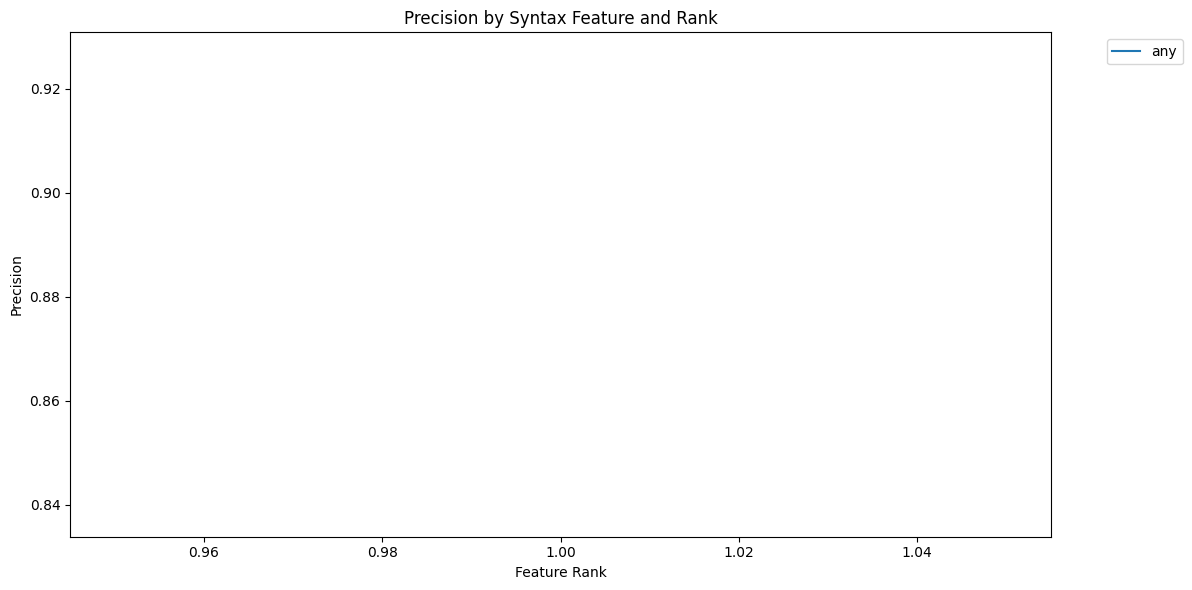

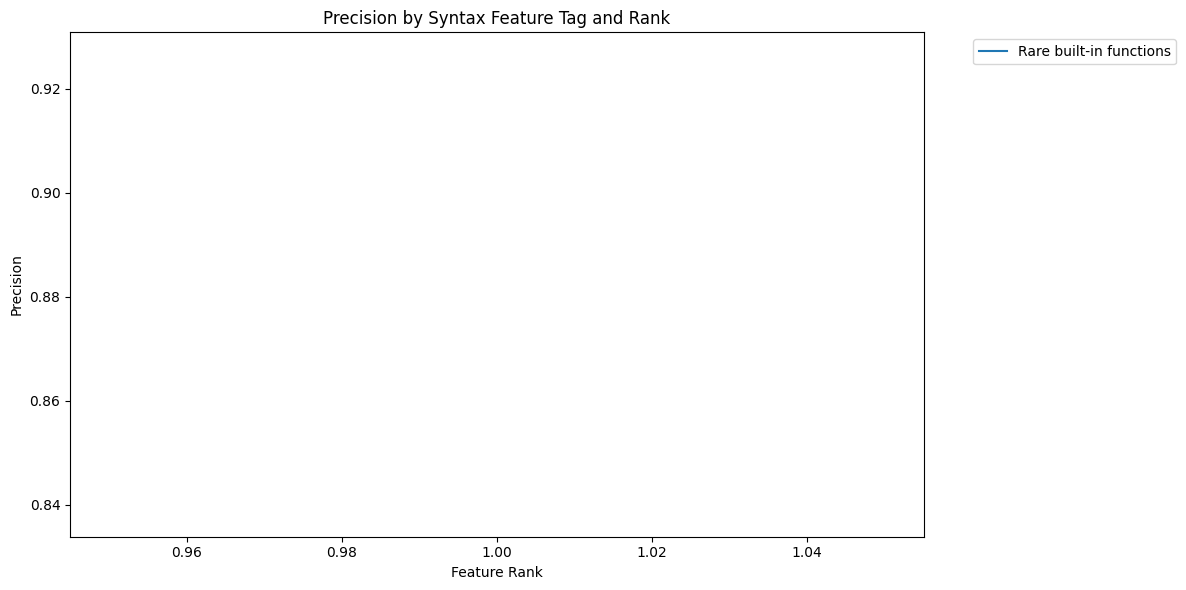

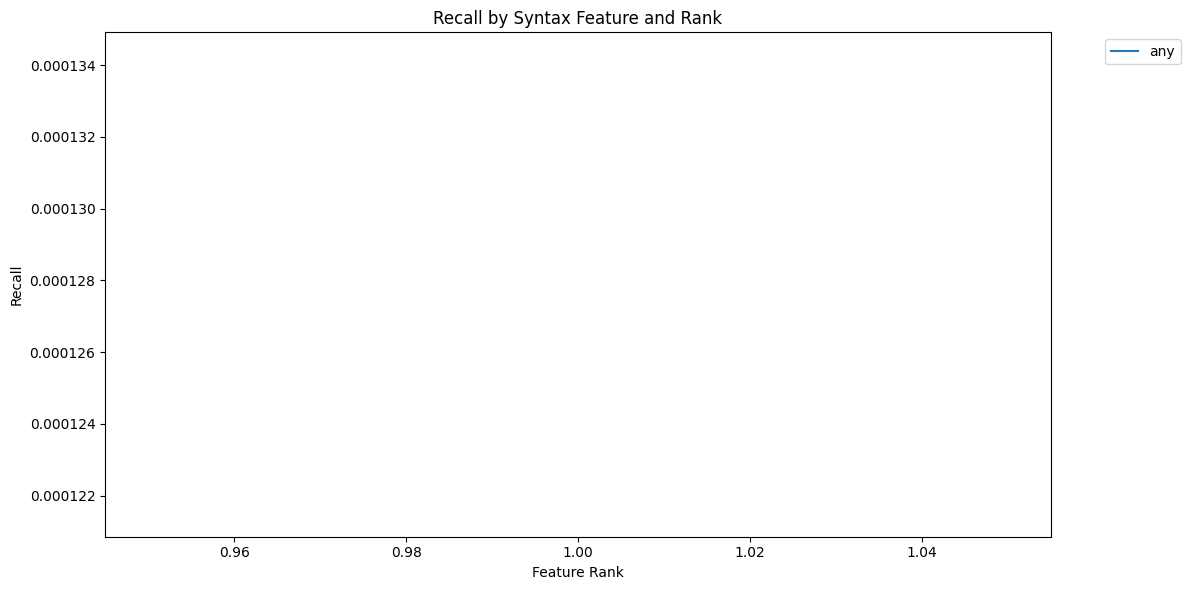

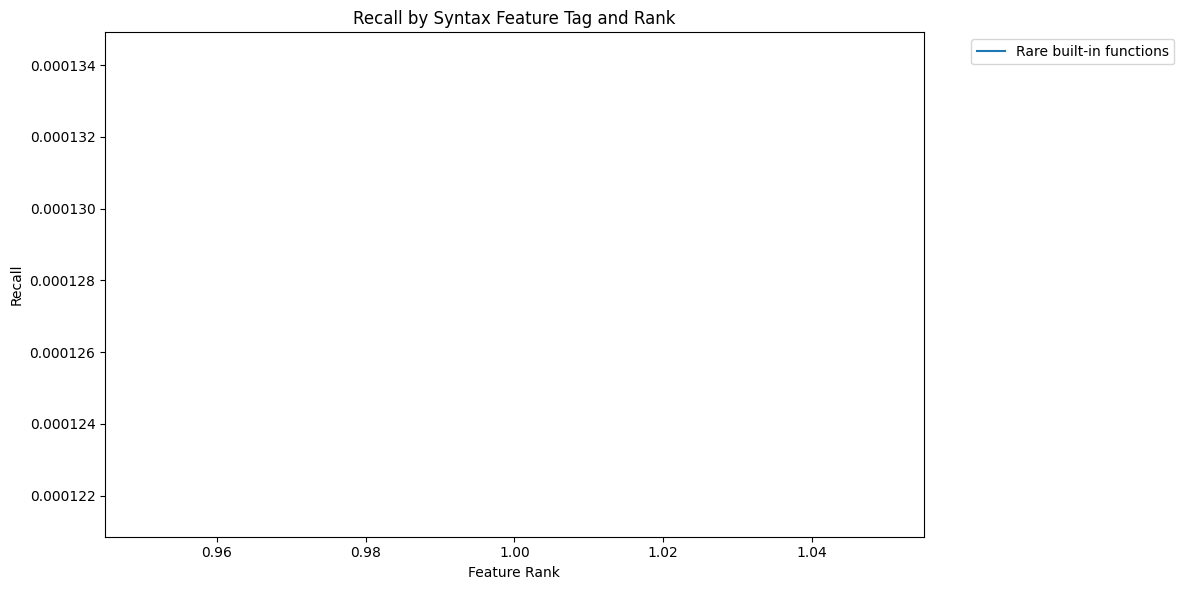

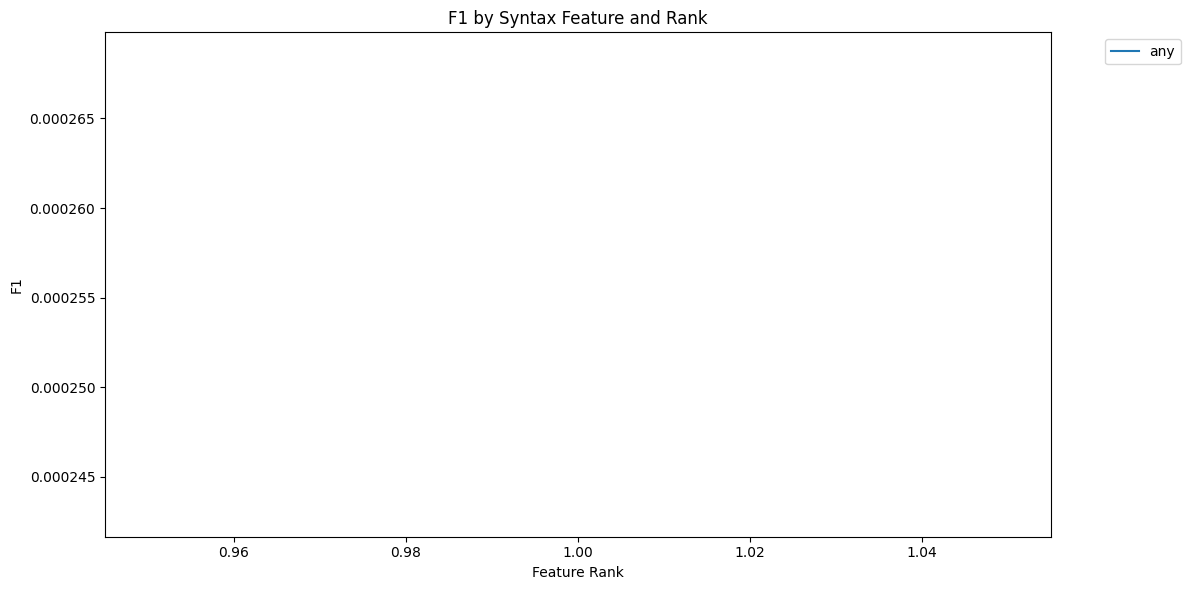

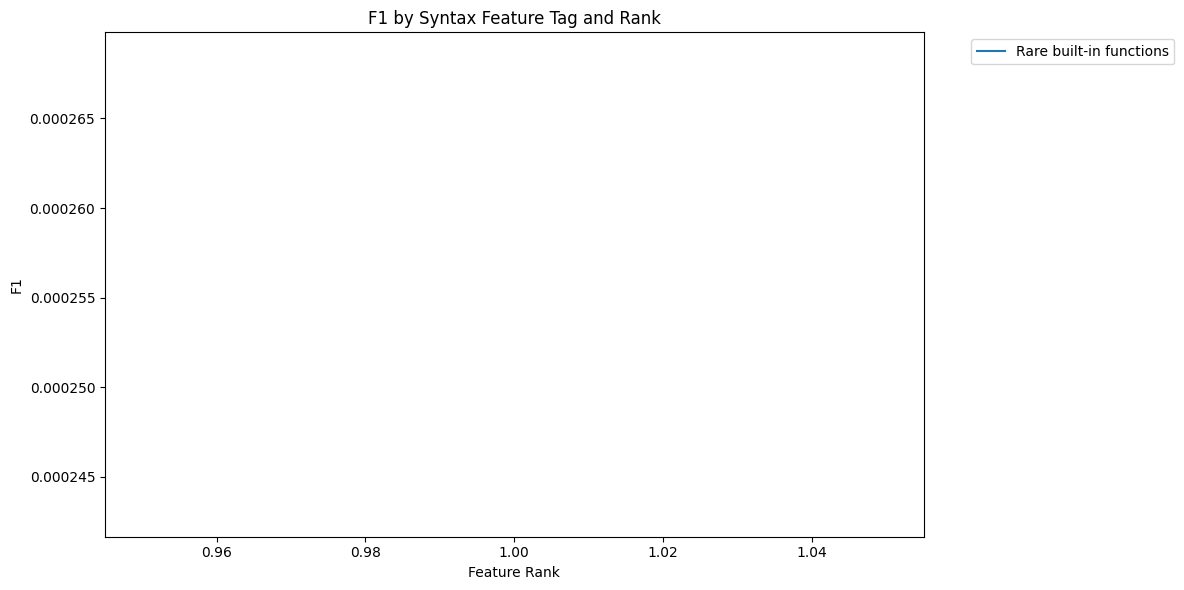

In [234]:

# Plot results
for metric in ['precision', 'recall', 'f1']:
    plot_metrics_by_feature(metrics_df, metric)
    plot_metrics_by_tag(metrics_df, metric)